# Section 2 - Churn, Classifier, Clustering

In this section, we tried to find a pattern of e-mail list churning behavior. Due to the fact that we don't have individual behavior data (activities by each users), we tried to classify users at firs, and according to each group of users, we found speicific patterns. Finally, for a new user, we give action recommendations. 
Note: Due to the time limitation, this model is only for baby registry 101, but it may apply to all e-mail lists.

In [1]:
import mysql.connector
import pandas as pd 
import matplotlib.pyplot as plt  
from datetime import datetime
from enum import Enum
from sklearn.cluster import KMeans

# Use ggplot as plt style
plt.style.use('ggplot') 

In [2]:
cnx = mysql.connector.connect(user='root', password='8xIt7ASAOzIh',
                              host='dw-sandbox-rds.ccia3ag00jrs.us-west-2.rds.amazonaws.com',
                              database='dw')

In [3]:
def churn_process(data):
    q = """SELECT *
                FROM (
                SELECT ID,
                       {0}_subscribed_at as subscribe,
                       {0}_unsubscribe_at as unsubscribe, 
                       DATEDIFF({0}_unsubscribe_at, {0}_subscribed_at)+1 as Subscribe_days,
                       {0}_delivered as Deliver,
                       {0}_open as Open,                   
                       {0}_click as Click,                   
                       {0}_delivered / (DATEDIFF({0}_unsubscribe_at, {0}_subscribed_at)+1) AS DELIVER_RATE,
                       {0}_open / {0}_delivered as OPEN_RATE,                    
                       {0}_click / {0}_open as CLICK_RATE,
                       DATEDIFF(original_arrival_date, {0}_subscribed_at) AS Urgency,
                       original_arrival_date,
                       source,
                       transactional_delivered
                FROM dim_users 
                WHERE {0}_subscribed_at IS NOT NULL 
                  AND {0}_unsubscribe_at IS NOT NULL 
                  AND DATE({0}_subscribed_at) >= '2017-02-08'          
                ) AS T1
            WHERE DELIVER_RATE < 1
    """.format(data)
    return pd.read_sql(q, con = cnx)

In [4]:
email_lists = [ u'baby_registry_101','newsletter','pregnancy_weekly','sponsored']

In [5]:
class Email(Enum): 
  BABY = 0
  NEWS = 1
  PREGANCY = 2
  SPONSORED = 3

In [6]:
#churns = []
#for email in Email:
#    df = churn_process(email_lists[email.value])
#    churns.append(df)
#    print email

Note: Here, we only make a model for baby registry 101. However, in the future, one can utilize the above code for all e-mail lists. 

## Data Cleaning 
    Here, we found some strange patterns, so we do a data cleaning 
    1. Some users only register for 1 day, but got more than 10 times of delivery. We only keep deliver rate (deliver times / subscribe_days) < 1. 
    1. Some users didn't open email, but click email.  This maybe caused from some people using windows outlook, so they don't open email but can clikc on the link. For those users, we make the open times = click times. 
    1. Some users' subscribe_at date is later than unsubscribe date. We remove those with negative subscribe_days. Those might be still active users. (Unsubscribe email but than subscribe again)
    1. Some users click more than open. That makes sense the user checked with e-mail several times. 

In [7]:
def data_cleaning(data):
    # Case: Overwhelming deliver times
    # Action : remove deliver_rate > 1
    data = data[data.DELIVER_RATE < 1]
    
    # Case: open = 0, click more than 0 
    # Action: Open = Click (Since it might come from system unable to trace this record)
    idx = (data.Open == 0) & (data.Click > 0) # index where open =0 and click > 0
    data.Open[idx] = data.Click[idx] # replace open with click 
    
    # Case: Unsubscribe and then subscribe (second time users)
    # Action: Since we are aiming to analyze unsubscribe users, we remove those users
    idx = data.Subscribe_days > 0 # index of positive subscription days
    data = data[idx]
    
    # Case: click serveral times for a e-mail(Click rate > 1)
    # Action: We keep those data
    return data

In [8]:
data = churn_process(email_lists[Email.BABY.value])

In [9]:
def churn_KMeans_cluster_nums(data):
    data = data_cleaning(data).fillna(0) # clean data and fill NAN with 0
    points = data.iloc[range(0,data.shape[0], 2), [7, 8, 9]] # 7, 8, 9 :Deliver rate, open rate, click rate
    
    # Import KMeans

    # Decide about how many clusters we would have
    ks = range(1, 10)
    inertias = []

    for k in ks:
        # Create a KMeans instance with k clusters: model
        model = KMeans(n_clusters = k)

        # Fit model to samples
        model.fit(points.fillna(0))

        # Append the inertia to the list of inertias
        inertias.append(model.inertia_)

    # Plot ks vs inertias
    plt.plot(ks, inertias, '-o')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.title("Determain number of K")
    plt.show()

/Users/pei-ciwu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


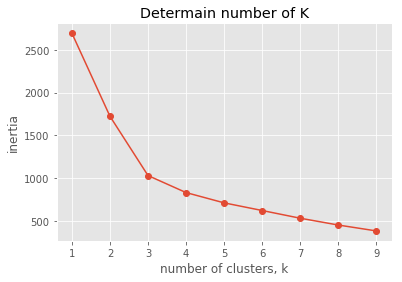

In [10]:
churn_KMeans_cluster_nums(data)

From the plot above, we decide we do a 3 cluster since it shows the best information loss and number of clusters. 

In [20]:
# Train test split
data = data_cleaning(data).fillna(0) # clean data and fill NAN with 0
points = data.iloc[range(0,data.shape[0], 2), [7, 8, 9]] # 7, 8, 9 :Deliver rate, open rate, click rate
new_points = data.iloc[range(1, data.shape[0], 2), [7, 8, 9]]# 7, 8, 9 :Deliver rate, open rate, click rate


/Users/pei-ciwu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
n = 3
model = KMeans(n_clusters = n)

# Fit model to points
model.fit(points)

# Determine the cluster labels of new_points: labels
labels = model.predict(new_points)



In [24]:
# Print out new_labels value counts
pd.DataFrame(labels).iloc[:, 0].value_counts()

0    3806
1    2701
2    1464
Name: 0, dtype: int64

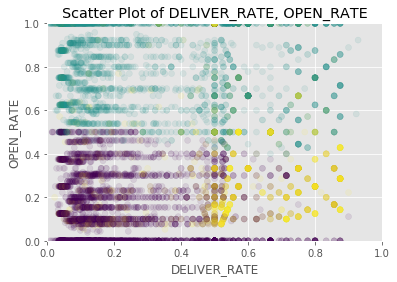

In [25]:
# Assign the columns of new_points: xs and ys
idx = [0, 1]
xs = new_points.iloc[:, idx[0]]
ys = new_points.iloc[:, idx[1]]

# Make a scatter plot of xs and ys, using labels to define the colors
plt.scatter(xs, ys, c = labels, alpha = 0.1)
plt.xlabel(new_points.columns[idx[0]])
plt.ylabel(new_points.columns[idx[1]])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Scatter Plot of " + new_points.columns[idx[0]] + ", " + new_points.columns[idx[1]])
plt.show()



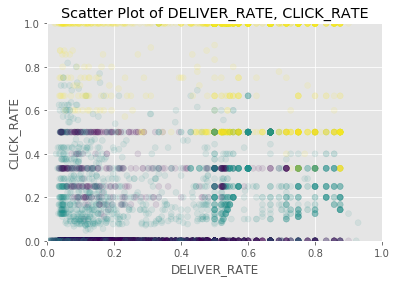

In [26]:
# Assign the columns of new_points: xs and ys
idx = [0, 2]
xs = new_points.iloc[:, idx[0]]
ys = new_points.iloc[:, idx[1]]

# Make a scatter plot of xs and ys, using labels to define the colors
plt.scatter(xs, ys, c = labels, alpha = 0.1)
plt.xlabel(new_points.columns[idx[0]])
plt.ylabel(new_points.columns[idx[1]])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Scatter Plot of " + new_points.columns[idx[0]] + ", " + new_points.columns[idx[1]])
plt.show()



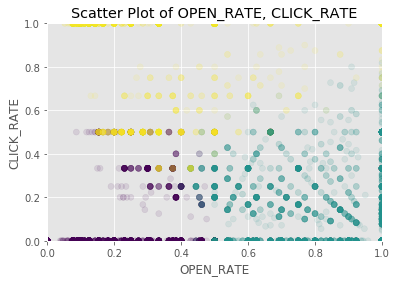

In [27]:
# Assign the columns of new_points: xs and ys
idx = [1, 2]
xs = new_points.iloc[:, idx[0]]
ys = new_points.iloc[:, idx[1]]

# Make a scatter plot of xs and ys, using labels to define the colors
plt.scatter(xs, ys, c = labels, alpha = 0.1)
plt.xlabel(new_points.columns[idx[0]])
plt.ylabel(new_points.columns[idx[1]])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("Scatter Plot of " + new_points.columns[idx[0]] + ", " + new_points.columns[idx[1]])
plt.show()



# Profile of each group and A/B testing
Here, we find center of each group, and base on each group, we do A/B testing in other features.


In [36]:
# Assign the cluster centers: centroids
centroids = pd.DataFrame(model.cluster_centers_)
centroids.columns = new_points.columns
centroids

,DELIVER_RATE,OPEN_RATE,CLICK_RATE
0,0.228210,0.147665,0.030858
1,0.333370,0.817357,0.156528
2,0.552065,0.395322,0.908738


In [39]:
# Add labels to new_points 
new_points_label = data.iloc[range(1, data.shape[0], 2),:]
new_points_label["label"] = labels

/Users/pei-ciwu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


## Subscribe_Days - A/B testing

In [49]:
new_points_label.groupby("label").Subscribe_days.mean()

label
0    82.135050
1    63.118475
2    24.622268
Name: Subscribe_days, dtype: float64

In [50]:
# A/B Testing - set for each group 
from scipy.stats import ttest_ind
cat0 = new_points_label[new_points_label.label == 0].Subscribe_days.values
cat1 = new_points_label[new_points_label.label == 1].Subscribe_days.values
cat2 = new_points_label[new_points_label.label == 2].Subscribe_days.values

In [59]:
print ttest_ind(cat0, cat1, equal_var = False)
print ttest_ind(cat0, cat2, equal_var = False)
print ttest_ind(cat1, cat2, equal_var = False)

Ttest_indResult(statistic=12.35928471053108, pvalue=1.265889185625222e-34)
Ttest_indResult(statistic=40.168180993081528, pvalue=3.6531431130538352e-292)
Ttest_indResult(statistic=23.461625129613083, pvalue=3.4174885678956343e-114)


##### Conclustion - For subscription days, 
1. Group 0 is significantly different than group 1.
1. Group 0 is significantly different than group 2.
1. Group 1 is significantly different than group 2.

## Urgency - A/B testing

In [54]:
new_points_label[(new_points_label.Urgency > -365) & (new_points_label.Urgency < 365)].groupby("label").Urgency.mean()

label
0    126.709695
1    122.880864
2    108.907703
Name: Urgency, dtype: float64

In [60]:
cat0 = new_points_label[new_points_label.label == 0].Urgency.values
cat1 = new_points_label[new_points_label.label == 1].Urgency.values
cat2 = new_points_label[new_points_label.label == 2].Urgency.values

In [61]:
print ttest_ind(cat0, cat1, equal_var = False)
print ttest_ind(cat0, cat2, equal_var = False)
print ttest_ind(cat1, cat2, equal_var = False)

Ttest_indResult(statistic=0.9807744461818384, pvalue=0.32679162814178886)
Ttest_indResult(statistic=3.0010202548826244, pvalue=0.0027363096732136187)
Ttest_indResult(statistic=2.7780253435882192, pvalue=0.005534553132468578)


##### Conclustion - For urgency,
1. There is no significant difference between group 0 and group 1. 
1. Group 0 is significantly different than group 2.
1. Group 1 is significantly different than group 2.

## Transaction delivered - A/B Test

In [63]:
new_points_label.groupby("label").transactional_delivered.mean()

label
0     9.256437
1    10.115143
2     5.599727
Name: transactional_delivered, dtype: float64

In [65]:
cat0 = new_points_label[new_points_label.label == 0].transactional_delivered.values
cat1 = new_points_label[new_points_label.label == 1].transactional_delivered.values
cat2 = new_points_label[new_points_label.label == 2].transactional_delivered.values

In [66]:
print ttest_ind(cat0, cat1, equal_var = False)
print ttest_ind(cat0, cat2, equal_var = False)
print ttest_ind(cat1, cat2, equal_var = False)

Ttest_indResult(statistic=-2.5035578106137337, pvalue=0.012323266027817092)
Ttest_indResult(statistic=11.322730764324342, pvalue=2.9888367840254225e-29)
Ttest_indResult(statistic=12.516452728113585, pvalue=2.7616910073000988e-35)


##### Conclustion - For transaction delivered,
1. Group 0 is significantly different than group 1.
1. Group 0 is significantly different than group 2.
1. Group 1 is significantly different than group 2.

## Soure - descirptive analysis

In [70]:
new_points_label.groupby("label").source.value_counts()

label  source                
0      registry                  2100
       checklist                 1096
       giveaway                   606
       0                            2
       email:pregnancy:direct       2
1      registry                  1633
       checklist                  743
       giveaway                   319
       0                            3
       email:pregnancy:direct       2
       event                        1
2      registry                   841
       checklist                  475
       giveaway                   133
       event                        9
       0                            3
       email:pregnancy:direct       3
Name: source, dtype: int64

# Future: action plan example

Here, we used unsupervised machine learning model to group users into 3 groups. The next powerful step could be - predict group category of a new users and give him/her a relative marketing action plan. Here is an example of click rate and open rate. 

In [82]:
# Base on classifier edge, we give an example category
# (not really base on the model but is close to it, only do this for visaulization example)
def click_rate_type(data):
    if data > 0.235:
        return "High"
    elif data > 0.11:
        return "Mid"
    else:
        return "Low"

In [74]:
action_example = data

In [75]:
action_example["Click_frequency"] = action_example.CLICK_RATE.apply(click_rate_type)

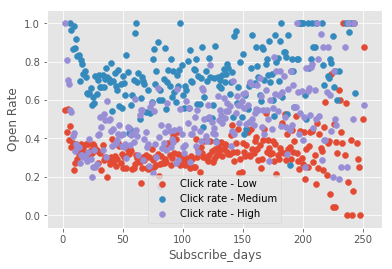

In [83]:
import matplotlib.pyplot as plt  
High = action_example[action_example.Click_frequency == 'High']
Mid = action_example[action_example.Click_frequency == 'Mid']
low = action_example[action_example.Click_frequency == 'Low']
low_plt = pd.DataFrame(low.groupby("Subscribe_days").OPEN_RATE.mean())
low_plt.reset_index(inplace=True)
Mid_plt = pd.DataFrame(Mid.groupby("Subscribe_days").OPEN_RATE.mean())
Mid_plt.reset_index(inplace=True)
High_plt = pd.DataFrame(High.groupby("Subscribe_days").OPEN_RATE.mean())
High_plt.reset_index(inplace=True)
plt.scatter(low_plt.Subscribe_days, low_plt.OPEN_RATE, label ='Click rate - Low')
plt.scatter(Mid_plt.Subscribe_days, Mid_plt.OPEN_RATE, label = "Click rate - Medium")
plt.scatter(High_plt.Subscribe_days, High_plt.OPEN_RATE, label = "Click rate - High")
plt.ylabel("Open Rate")
plt.xlabel("Subscribe_days")
plt.legend()

plt.show()

Bese on this plot, we can see if a new users with 50 days records but with 0.2 open rate, and we put it into click rate - high, we might try to increase his/her open rate to 0.4-0.6 range. On the other hand, if a new user is classified as a low click rate but with a high open rate, we might decrease our e-mail deliver frequency as a recommendations. 